In [1]:
import pystac_client
import planetary_computer
import fsspec
import xarray as xr

import geopandas as gpd

import calendar

In [3]:
def mth_end(month,year):
    if month in (1,3,5,7,8,10,12):
        return str(year)+'-'+str(month)+'-31'
    if month in (4,6,9,11):
        return str(year)+'-'+str(month)+'-30'
    if calendar.isleap(year):
        return str(year)+'-02-29'
    return str(year)+'-02-28'

In [4]:
def mth_arid_index(month,year,evap,prec):
    m_prec = prec.sel(time=slice(str(year)+'-'+str(month)+'-01',mth_end(month,year)))
    m_evap = evap.sel(time=slice(str(year)+'-'+str(month)+'-01',mth_end(month,year)))
    
    total_prec = m_prec.sum(dim='time')
    total_evap = m_evap.sum(dim='time')
    
    return total_prec/total_evap

In [8]:
# assumes ca_shp and darray already have same crs
def ca_clip(ds,darray,ca_shp):
    crs = ds.attrs['coordinate_system']
    da_clip = darray.rio.write_crs(crs)
    return da_clip.rio.clip(ca_shp.geometry, ca_shp.crs)  

In [17]:
# ds = gridemet dataset
#
# n = number of years used in averaging 

def aridity_index(ds,year,n,ca_shp):
    
    # ** add stop for date out of range **
    # select full range over which to compute average of monthly aridity indices
    prec = ds["precipitation_amount"].sel(time=slice(str(year-n+1)+'-01-01',str(year)+'-12-31'))
    evap = ds["potential_evapotranspiration"].sel(time=slice(str(year-n+1)+'-01-01',str(year)+'-12-31'))
    
    # clip to CA
    ca_prec = ca_clip(ds,prec,ca_shp)
    ca_evap = ca_clip(ds,evap,ca_shp)
    
    #stack = mth_arid_index(1,year-n+1,ca_evap,ca_prec)
    stack = xr.DataArray()
    for i in range(1,13):
        for j in range(year-n+1,year+1):
            month_ai = mth_arid_index(i,j,ca_evap,ca_prec)
            stack = xr.concat([stack,month_ai], dim='time', combine_attrs='drop')
    # drop first layer (empty dataarray)
    stack = stack.sel(time=slice(1,12*n))
    ai = stack.mean(dim='time')
    
    # update attributes
    ai.attrs['long_name']='California '+str(year)+' Aridity Index as Average of Monthly Aridity Indices '+str(year-n+1)+'-'+str(year)
    ai.attrs['coordinate_system']=ds.attrs['coordinate_system']
    ai.attrs['start_month']='1-'+str(year-n+1)
    ai.attrs['end_month']='12-'+str(2020)
    
    return ai

In [10]:
# --------------------------------------------------------------------------
# LOAD GRIDMET DATASET

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
gridmet = catalog.get_collection("gridmet")
asset = planetary_computer.sign(gridmet.assets["zarr-abfs"])

store = fsspec.get_mapper(asset.href, **asset.extra_fields["xarray:storage_options"])
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])

# --------------------------------------------------------------------------
# LOAD CA SHAPEFILE AND MATCH WITH DS CRS

# extract crs from xarray.DataArray
crs= ds.attrs['coordinate_system']

# import shapefile
ca_shape_path = "/home/jovyan/Sedgwick_Reserve/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)

# match CRS
ca_shp = ca_shape.to_crs(ds.attrs['coordinate_system'])

In [18]:
trial = aridity_index(ds,2020,1,ca_shp)

In [19]:
trial

<xarray.DataArray (lat: 227, lon: 249)>
dask.array<mean_agg-aggregate, shape=(227, 249), dtype=float64, chunksize=(227, 249), chunktype=numpy.ndarray>
Coordinates:
    crs      int64 0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
Attributes:
    long_name:          California 2020 Aridity Index as Average of Monthly A...
    coordinate_system:  EPSG:4326
    start_month:        12020
    end_month:          12-2020

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


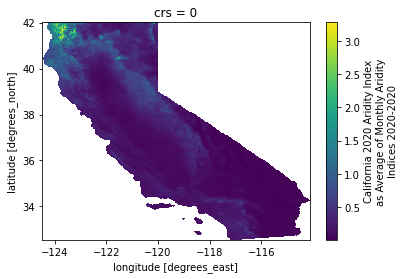

In [20]:
trial.plot()